# Multilevel Regression and Post-stratification

## Regression and Effect Modification

What are we even doing when we fit a regression model? Is a question that arises when first learning the tools of the trade and again when debugging strange results of your thousandth logistic regression model.

This notebook is intended to showcase how regression can be seen as a method for automating the calculation of stratum specific conditional effects. Additionally, we'll see how we can enrich regression models by a post-stratification adjustment with knowledge of the appropriate stratum specific weights. This technique of multilevel regression and post stratification (MrP) is often used in the context of national surveys where we have knowledge of the population weights appropriate to different demographic groups. It can be used in wide variety of areas ranging from political polling to online market research. We will demonstrate how to fit and and assess these models using Bambi. 

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## Risk Stratification

First consider this example of heart transplant patients adapted from Hernan and Robins' excellent book *Causal Inference: What if*. Here we have a number of patients (anonymised with named for the Greek Gods). The data records the outcomes of a heart transplant program for those who were part of the program and those who were not. We also see the different risk levels of each patient assigned the treatment. 

What we want to show here is that a regression model fit to this data automatically accounts for the weighting appropriate to the different risk strata.

In [2]:
df = pd.DataFrame(
    {
        "name": [
            "Rheia",
            "Kronos",
            "Demeter",
            "Hades",
            "Hestia",
            "Poseidon",
            "Hera",
            "Zeus",
            "Artemis",
            "Apollo",
            "Leto",
            "Ares",
            "Athena",
            "Hephaestus",
            "Aphrodite",
            "Cyclope",
            "Persephone",
            "Hermes",
            "Hebe",
            "Dionysus",
        ],
        "Risk_Strata": [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        "Treatment": [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        "Outcome": [0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    }
)

df["Treatment_x_Risk_Strata"] = df.Treatment * df.Risk_Strata

df

,name,Risk_Strata,Treatment,Outcome,Treatment_x_Risk_Strata
0,Rheia,0,0,0,0
1,Kronos,0,0,1,0
2,Demeter,0,0,0,0
3,Hades,0,0,0,0
4,Hestia,0,1,0,0
5,Poseidon,0,1,0,0
6,Hera,0,1,0,0
7,Zeus,0,1,1,0
8,Artemis,1,0,1,0
9,Apollo,1,0,1,0


If the treatment assignment procedure involved complete randomisation then we might expect a reasonable balance of strata effects across the treated and non-treated. In this sample we see (perhaps counter intuitively) that the treatment seems to induce a higher rate of death than the non-treated group.

In [3]:
simple_average = df.groupby("Treatment")[["Outcome"]].mean().rename({"Outcome": "Share"}, axis=1)
simple_average

,Share
Treatment,
0,0.428571
1,0.538462


Which suggests an alarming causal effect whereby the treatment seems to increase risk of death in the population. 

In [4]:
causal_risk_ratio = simple_average.iloc[1]["Share"] / simple_average.iloc[0]["Share"]
print("Causal Risk Ratio:", causal_risk_ratio)

Causal Risk Ratio: 1.2564102564102564


This finding we know on inspection is driven by the imbalance in the risk strata across the treatment groups.

In [5]:
df.groupby("Risk_Strata")[["Treatment"]].count().assign(
    proportion=lambda x: x["Treatment"] / len(df)
)

,Treatment,proportion
Risk_Strata,,
0,8,0.4
1,12,0.6


We can correct for this by weighting the results by the share each group represents across the `Risk_Strata`. In other words when we correct for the population size at the different levels of risk we get a better estimate of the effect.

In [6]:
weighted_avg = (
    df.groupby(["Risk_Strata", "Treatment"])[["Outcome"]]
    .mean()
    .reset_index()
    .pivot(index="Treatment", columns=["Risk_Strata"], values="Outcome")
    .assign(formula="0.4*0.25 + 0.6*0.66")
    .assign(
        weighted_average=lambda x: x[0] * (df[df["Risk_Strata"] == 0].shape[0] / len(df))
        + x[1] * (df[df["Risk_Strata"] == 1].shape[0] / len(df))
    )
)

weighted_avg

Risk_Strata,0,1,formula,weighted_average
Treatment,,,,
0,0.25,0.666667,0.4*0.25 + 0.6*0.66,0.5
1,0.25,0.666667,0.4*0.25 + 0.6*0.66,0.5


From which we can derive a more sensible treatment effect.

In [7]:
causal_risk_ratio = (
    weighted_avg.iloc[1]["weighted_average"] / weighted_avg.iloc[0]["weighted_average"]
)

print("Causal Risk Ratio:", causal_risk_ratio)

Causal Risk Ratio: 1.0


## Regression as Stratification

So far, so good. But so what? 

The point here is that the above series of steps can be difficult to accomplish with more complex sets of groups and risk profiles. So it's useful to understand that regression can be used to automatically account for the variation in outcome effects across the different strata of our population. 

In [8]:
reg = bmb.Model("Outcome ~ 1 + Treatment", df)
results = reg.fit()

reg_strata = bmb.Model("Outcome ~ 1 + Treatment + Risk_Strata + Treatment_x_Risk_Strata", df)
results_strata = reg_strata.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Outcome_sigma, Intercept, Treatment]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Outcome_sigma, Intercept, Treatment, Risk_Strata, Treatment_x_Risk_Strata]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We can now inspect the treatment effect and the implied causal risk ratio in each model. We can quickly recover that controlling for the __right__ variables in our regression model automatically adjusts the treatment effect downwards towards 0. 

In [9]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.432,0.211,0.065,0.875,0.003,0.002,4393.0,2686.0,1.0
Treatment,0.103,0.266,-0.416,0.592,0.004,0.004,4516.0,2237.0,1.0
Outcome_sigma,0.544,0.093,0.390,0.723,0.002,0.001,3636.0,2846.0,1.0


In [10]:
az.summary(results_strata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.251,0.268,-0.281,0.742,0.006,0.004,2220.0,2469.0,1.0
Treatment,-0.002,0.381,-0.708,0.761,0.008,0.006,2057.0,2134.0,1.0
Risk_Strata,0.406,0.422,-0.374,1.180,0.010,0.007,1973.0,2290.0,1.0
Treatment_x_Risk_Strata,0.011,0.527,-1.047,0.948,0.013,0.010,1690.0,1718.0,1.0
Outcome_sigma,0.535,0.098,0.364,0.708,0.002,0.001,2601.0,2314.0,1.0


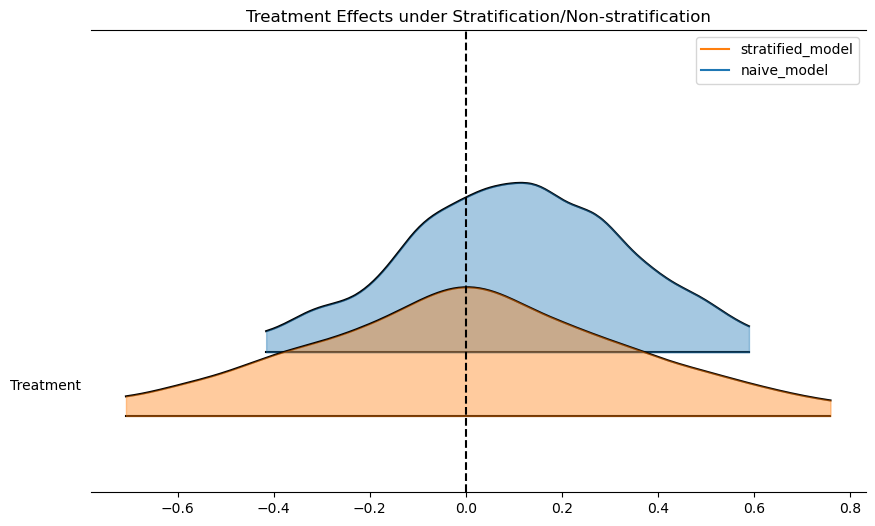

In [11]:
ax = az.plot_forest(
    [results, results_strata],
    model_names=["naive_model", "stratified_model"],
    var_names=["Treatment"],
    kind="ridgeplot",
    ridgeplot_alpha=0.4,
    combined=True,
    figsize=(10, 6),
)
ax[0].axvline(0, color="black", linestyle="--")
ax[0].set_title("Treatment Effects under Stratification/Non-stratification");

We can even see this in the predicted outcomes for the model. This is an important step. The regression model automatically adjusts for the risk profile within the appropriate strata in the data "seen" by the model.

In [12]:
new_df = df[["Risk_Strata"]].assign(Treatment=1).assign(Treatment_x_Risk_Strata=1)
new_preds = reg_strata.predict(results_strata, kind="pps", data=new_df, inplace=False)
print("Expected Outcome in the Treated")
new_preds["posterior_predictive"]["Outcome"].mean().item()

Expected Outcome in the Treated


0.500911899831879

In [13]:
new_df = df[["Risk_Strata"]].assign(Treatment=0).assign(Treatment_x_Risk_Strata=0)
new_preds = reg_strata.predict(results_strata, kind="pps", data=new_df, inplace=False)
print("Expected Outcome in the Untreated")

new_preds["posterior_predictive"]["Outcome"].mean().item()

Expected Outcome in the Untreated


0.49462444720219717

We can see these results more clearly using `bambi` model interpretation functions to see the predictions within a specific strata. 

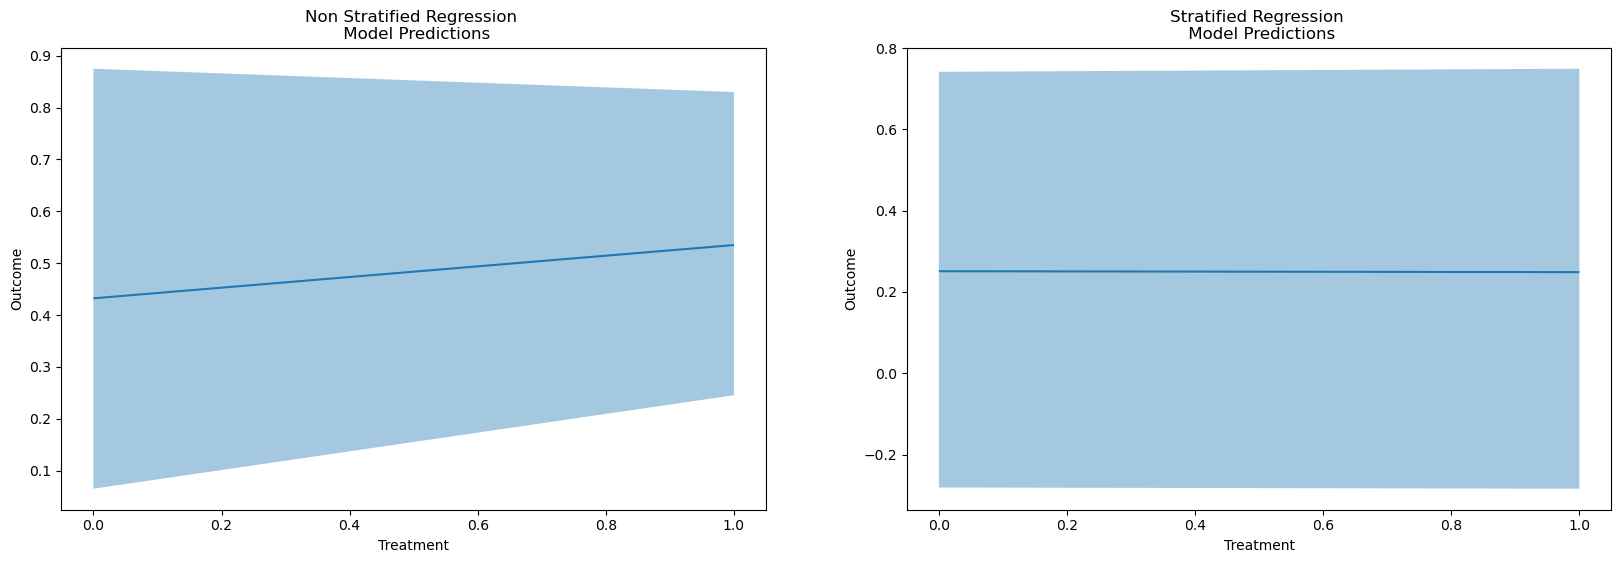

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
bmb.interpret.plot_predictions(reg, results, covariates=['Treatment'], ax=axs[0]);
bmb.interpret.plot_predictions(reg_strata, results_strata, covariates=['Treatment'], ax=axs[1]);
axs[0].set_title("Non Stratified Regression \n Model Predictions")
axs[1].set_title("Stratified Regression \n Model Predictions");

Hernan and Robins expand on these foundational observations and elaborate the implications for causal inference and the bias of confounding variables. We won't go into these details, as we instead we want to draw out the connection with controlling for the risk of non-representative sampling. The usefulness of "representative-ness" as an idea is disputed in the statistical literature due to the vagueness of the term. To say a sample is representative is ussually akin to meaning that it was generated from a high-quality probability sampling design. This design is specified to avoid the creep of bias due to selection effects contaminating the results.

We've seen how regression can automate stratification across the levels of covariates in the model conditional on the sample data. But what if the prevalence of the risk-profile in your data does not reflect the prevalance of risk in the wider population? Then the regression model will automatically adjust to the prevalence in the sample, but it is not adjusting to the correct weights. 

## The Need for Post-Stratification

In the context of national survey design there is always a concern that the sample respondents may be more or less representative of the population across different key demographics e.g. it's unlikely we would put much faith in the survey's accuracy if it had 90% male respondents on a question about the lived experience of women. Given that we can know before hand that certain demographic splits are not relective of the census data, we can use this information to appropriately re-weight the regressions fit to non-representative survey data. 

We'll demonstrate the idea of multi-level regression and post-stratification adjustment by replicating some of the steps discussed in Martin, Philips and Gelmen's ["Multilevel Regression and Poststratification Case Studies"](https://bookdown.org/jl5522/MRP-case-studies/). 

They cite data from the Cooperative Congressional Election Study (Schaffner, Ansolabehere, and Luks (2018)), a US nationwide survey designed by a consortium of 60 research teams and administered by YouGov. The outcome of interest is a binary question: Should employers decline coverage of abortions in insurance plans?

In [15]:
cces_all_df = pd.read_csv("data/mr_p_cces18_common_vv.csv.gz", low_memory=False)
cces_all_df.head()

,caseid,commonweight,commonpostweight,vvweight,vvweight_post,tookpost,CCEStake,birthyr,gender,educ,...,CL_party,CL_2018gvm,CL_2018pep,CL_2018pvm,starttime,endtime,starttime_post,endtime_post,DMA,dmaname
0,123464282,0.940543,0.7936,0.740858,0.641412,2,1,1964,2,4,...,11.0,1.0,NaN,NaN,04oct2018 02:47:10,09oct2018 04:16:31,11nov2018 00:41:13,11nov2018 01:21:53,512.0,BALTIMORE
1,170169205,0.769724,0.7388,0.425236,0.415134,2,1,1971,2,2,...,13.0,NaN,6.0,2.0,02oct2018 06:55:22,02oct2018 07:32:51,12nov2018 00:49:50,12nov2018 01:08:43,531.0,"""TRI-CITIES"
2,175996005,1.491642,1.3105,1.700094,1.603264,2,1,1958,2,3,...,13.0,5.0,NaN,NaN,07oct2018 00:48:23,07oct2018 01:38:41,12nov2018 21:49:41,12nov2018 22:19:28,564.0,CHARLESTON-HUNTINGTON
3,176818556,5.104709,4.6304,5.946729,5.658840,2,1,1946,2,6,...,4.0,3.0,NaN,3.0,11oct2018 15:20:26,11oct2018 16:18:42,11nov2018 13:24:16,11nov2018 14:00:14,803.0,LOS ANGELES
4,202120533,0.466526,0.3745,0.412451,0.422327,2,1,1972,2,2,...,3.0,5.0,NaN,NaN,08oct2018 02:31:28,08oct2018 03:03:48,15nov2018 01:04:16,15nov2018 01:57:21,529.0,LOUISVILLE


### Cleaning Census Data

To prepare the census data for modelling we need to break the demographic data into appropriate stratum. We will break out these groupings as along broad categories familiar to audiences of election coverage news. Even these steps amount to a significant choice where we use our knowledge of pertinent demographics to decide upon the key strata we wish to represent in our model, as we seek to better predict and understand the voting outcome. 

In [16]:
states = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
]


numbers = list(range(1, 56, 1))

lkup_states = dict(zip(numbers, states))
lkup_states


ethnicity = [
    "White",
    "Black",
    "Hispanic",
    "Asian",
    "Native American",
    "Mixed",
    "Other",
    "Middle Eastern",
]
numbers = list(range(1, 9, 1))
lkup_ethnicity = dict(zip(numbers, ethnicity))
lkup_ethnicity


edu = ["No HS", "HS", "Some college", "Associates", "4-Year College", "Post-grad"]
numbers = list(range(1, 7, 1))
lkup_edu = dict(zip(numbers, edu))


def clean_df(df):
    ## 0 Oppose and 1 Support
    df["abortion"] = np.abs(df["CC18_321d"] - 2)
    df["state"] = df["inputstate"].map(lkup_states)
    ## dichotomous (coded as -0.5 Female, +0.5 Male)
    df["male"] = np.abs(df["gender"] - 2) - 0.5
    df["eth"] = df["race"].map(lkup_ethnicity)
    df["eth"] = np.where(
        df["eth"].isin(["Asian", "Other", "Middle Eastern", "Mixed", "Native American"]),
        "Other",
        df["eth"],
    )
    df["age"] = 2018 - df["birthyr"]
    df["age"] = pd.cut(
        df["age"].astype(int),
        [0, 29, 39, 49, 59, 69, 120],
        labels=["18-29", "30-39", "40-49", "50-59", "60-69", "70+"],
        ordered=True,
    )
    df["edu"] = df["educ"].map(lkup_edu)
    df["edu"] = np.where(df["edu"].isin(["Some college", "Associates"]), "Some college", df["edu"])

    df = df[["abortion", "state", "eth", "male", "age", "edu", "caseid"]]
    return df.dropna()


statelevel_predictors_df = pd.read_csv("data/mr_p_statelevel_predictors.csv")

cces_all_df = clean_df(cces_all_df)
cces_all_df.head()

,abortion,state,eth,male,age,edu,caseid
0,1.0,MS,Other,-0.5,50-59,Some college,123464282
1,1.0,WA,White,-0.5,40-49,HS,170169205
2,1.0,RI,White,-0.5,60-69,Some college,175996005
3,0.0,CO,Other,-0.5,70+,Post-grad,176818556
4,1.0,MA,White,-0.5,40-49,HS,202120533


We will now show how estimates drawn from sample data (biased for whatever reasons of chance and circumstance) can be improved by using a post-stratification adjustment based on known facts about the size of the population in each strata considered in the model. This additional step is simply another modelling choice - another way to invest our model with information. In this manner the technique comes naturally in the Bayesian perspective. 

### Biased Sample

Consider a deliberately biased sample. Biased away from the census data and in this manner we show how to better recover population level estimates by incorporating details about the census population size across each of the stratum.

In [17]:
cces_df = cces_all_df.merge(statelevel_predictors_df, left_on="state", right_on="state", how="left")
cces_df["weight"] = (
    5 * cces_df["repvote"]
    + (cces_df["age"] == "18-29") * 0.5
    + (cces_df["age"] == "30-39") * 1
    + (cces_df["age"] == "40-49") * 2
    + (cces_df["age"] == "50-59") * 4
    + (cces_df["age"] == "60-69") * 6
    + (cces_df["age"] == "70+") * 8
    + (cces_df["male"] == 1) * 20
    + (cces_df["eth"] == "White") * 1.05
)

cces_df = cces_df.sample(5000, weights="weight", random_state=1000)
cces_df.head()

,abortion,state,eth,male,age,edu,caseid,repvote,region,weight
35171,0.0,KY,White,-0.5,60-69,HS,415208636,0.656706,South,10.333531
5167,0.0,NM,White,0.5,60-69,No HS,412278020,0.453492,West,9.317460
52365,0.0,OK,Hispanic,-0.5,30-39,4-Year College,419467449,0.693047,South,4.465237
23762,1.0,WV,White,-0.5,50-59,Post-grad,413757903,0.721611,South,8.658053
48197,0.0,RI,White,0.5,50-59,4-Year College,417619385,0.416893,Northeast,7.134465


### Visualise the Bias

Now we plot the outcome of expected shares within each demographic bucket across both the biased sample and the census data. 


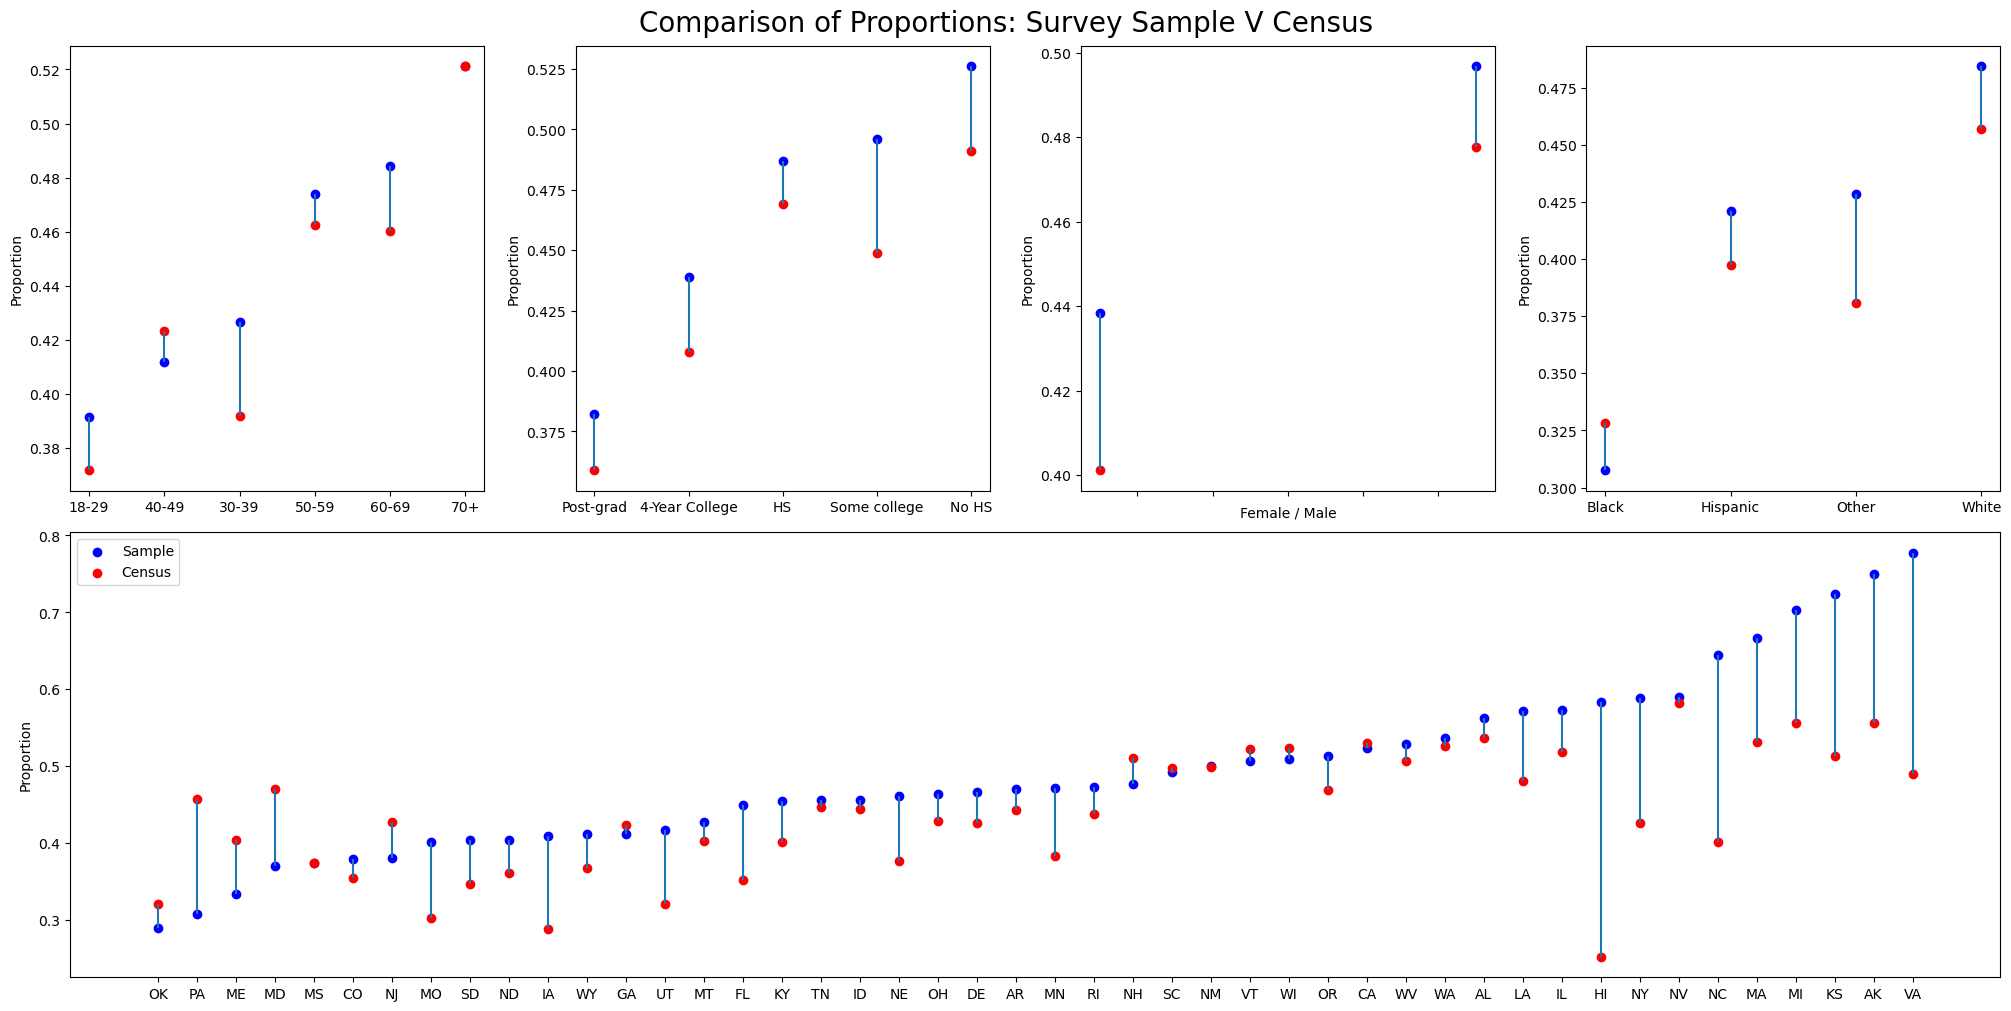

In [18]:
mosaic = """
    ABCD
    EEEE
    """

fig = plt.figure(layout="constrained", figsize=(20, 10))
ax_dict = fig.subplot_mosaic(mosaic)


def plot_var(var, ax):
    a = (
        cces_df.groupby(var, observed=False)[["abortion"]]
        .mean()
        .rename({"abortion": "share"}, axis=1)
        .reset_index()
    )
    b = (
        cces_all_df.groupby(var, observed=False)[["abortion"]]
        .mean()
        .rename({"abortion": "share_census"}, axis=1)
        .reset_index()
    )
    a = a.merge(b).sort_values("share")
    ax_dict[ax].vlines(a[var], a.share, a.share_census)
    ax_dict[ax].scatter(a[var], a.share, color="blue", label="Sample")
    ax_dict[ax].scatter(a[var], a.share_census, color="red", label="Census")
    ax_dict[ax].set_ylabel("Proportion")


plot_var("age", "A")
plot_var("edu", "B")
plot_var("male", "C")
plot_var("eth", "D")
plot_var("state", "E")

ax_dict["E"].legend()

ax_dict["C"].set_xticklabels([])
ax_dict["C"].set_xlabel("Female / Male")
plt.suptitle("Comparison of Proportions: Survey Sample V Census", fontsize=20);

In [19]:
def get_se_bernoulli(p, n):
    return np.sqrt(p * (1 - p) / n)


sample_cces_estimate = {
    "mean": np.mean(cces_df["abortion"].astype(float)),
    "se": get_se_bernoulli(np.mean(cces_df["abortion"].astype(float)), len(cces_df)),
}
sample_cces_estimate


sample_cces_all_estimate = {
    "mean": np.mean(cces_all_df["abortion"].astype(float)),
    "se": get_se_bernoulli(np.mean(cces_all_df["abortion"].astype(float)), len(cces_df)),
}
sample_cces_all_estimate

summary = pd.DataFrame([sample_cces_all_estimate, sample_cces_estimate])
summary["data"] = ["Full Data", "Biased Data"]
summary

,mean,se,data
0,0.434051,0.007009,Full Data
1,0.465000,0.007054,Biased Data


## Modelling the Data

To facilitate regression based stratification we first need a regression model. In our case we will fit the following multi-level regression model with intercept terms for each for each of the groups in our demographic stratum. In this way we try to account for the appropriate set of variables (as in the example above) to better specify the effect modification due to membership within a particular demographic stratum. 

We will fit the model using `bambi` using the binomial link function on the biased sample data. But first we aggregate up by demographic strata and count the occurences within each strata. 

In [20]:
model_df = (
    cces_df.groupby(["state", "eth", "male", "age", "edu"], observed=False)
    .agg({"caseid": "nunique", "abortion": "sum"})
    .reset_index()
    .sort_values("abortion", ascending=False)
    .rename({"caseid": "n"}, axis=1)
    .merge(statelevel_predictors_df, left_on="state", right_on="state", how="left")
)
model_df["abortion"] = model_df["abortion"].astype(int)
model_df["n"] = model_df["n"].astype(int)
model_df.head()

,state,eth,male,age,edu,n,abortion,repvote,region
0,ID,White,-0.5,70+,HS,32,18,0.683102,West
1,ID,White,0.5,70+,4-Year College,20,16,0.683102,West
2,WV,White,0.5,70+,Some college,17,13,0.721611,South
3,WV,White,0.5,70+,4-Year College,15,12,0.721611,South
4,ID,White,0.5,70+,Post-grad,17,11,0.683102,West


### Fit Base Model to Biased Sample

Here we use some of bambi's latest functionality to assess the interaction effects between the variables. 

In [21]:
%%capture
formula = """ p(abortion, n) ~ C(state) + C(eth) + C(edu) + male + repvote"""

base_model = bmb.Model(formula, model_df, family="binomial")

result = base_model.fit(
    random_seed=100,
    target_accept=0.95,
    inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},
)

We plot the predicted outcomes within each group using the `plot_predictions` function. 

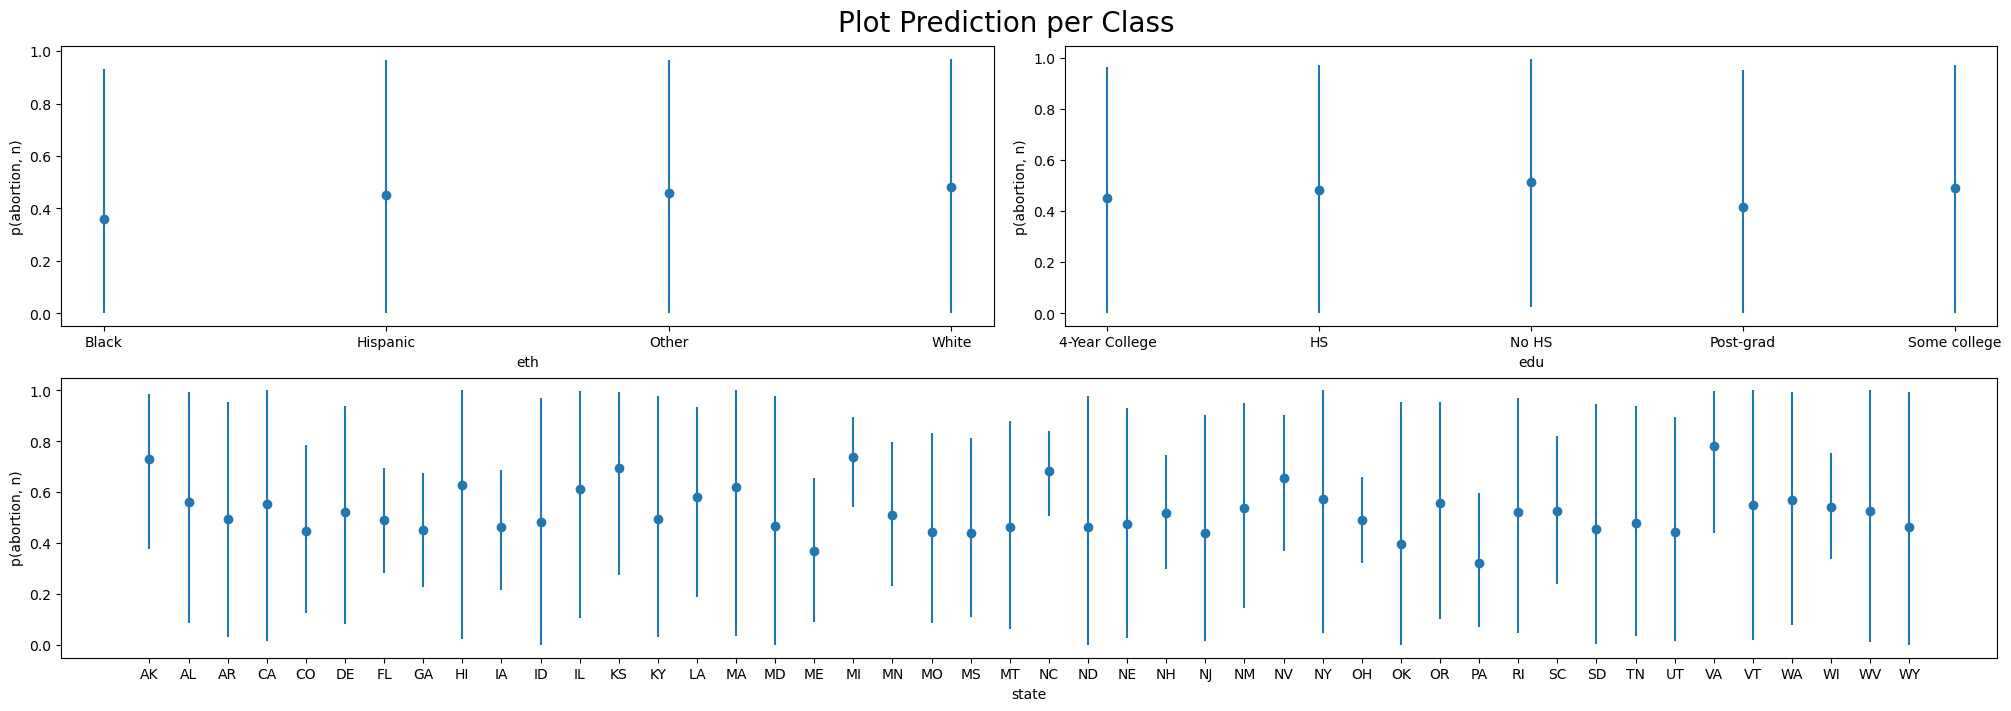

In [22]:
mosaic = """
    AABB
    CCCC
    """

fig = plt.figure(layout="constrained", figsize=(20, 7))
axs = fig.subplot_mosaic(mosaic)

bmb.interpret.plot_predictions(base_model, result, "eth", ax=axs["A"])
bmb.interpret.plot_predictions(base_model, result, "edu", ax=axs["B"])
bmb.interpret.plot_predictions(base_model, result, "state", ax=axs["C"])
plt.suptitle("Plot Prediction per Class", fontsize=20);

More interesting we can use the comparison functionality to compare differences in `eth` conditional on `age` and `edu`. Where we can see that the differences between ethnicities are pretty stable across all age groups, slightly shifted by within the `Post-grad` level of education. 

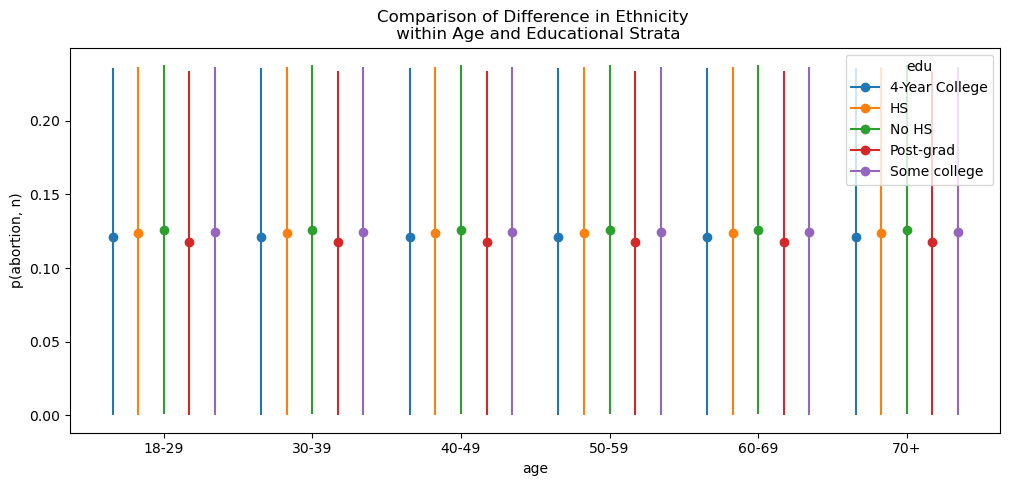

In [23]:
fig, ax = bmb.interpret.plot_comparisons(
    model=base_model,
    idata=result,
    contrast={"eth": ["Black", "White"]},
    conditional=["age", "edu"],
    comparison_type="diff",
    subplot_kwargs={"main": "age", "group": "edu"},
    fig_kwargs={"figsize": (12, 5), "sharey": True},
    legend=True,
)
ax[0].set_title("Comparison of Difference in Ethnicity \n within Age and Educational Strata");

We can pull these specific estimates out into a table for closer inspection to see that the differences in response expected between the extremes of educational attainment are moderated by state iand race.

In [24]:
bmb.interpret.comparisons(
    model=base_model,
    idata=result,
    contrast={"edu": ["Post-grad", "No HS"]},
    conditional={"eth": ["Black", "White"], "state": ["NY", "CA", "ID", "VA"]},
    comparison_type="diff",
)

,term,estimate_type,value,eth,state,male,repvote,estimate,lower_3.0%,upper_97.0%
0,edu,diff,"(Post-grad, No HS)",Black,NY,0.0,0.530191,0.096462,0.000582,0.196874
1,edu,diff,"(Post-grad, No HS)",Black,CA,0.0,0.530191,0.081741,0.000008,0.194185
2,edu,diff,"(Post-grad, No HS)",Black,ID,0.0,0.530191,0.088716,0.000044,0.190990
3,edu,diff,"(Post-grad, No HS)",Black,VA,0.0,0.530191,0.125920,0.020739,0.214231
4,edu,diff,"(Post-grad, No HS)",White,NY,0.0,0.530191,0.097404,0.000137,0.195786
5,edu,diff,"(Post-grad, No HS)",White,CA,0.0,0.530191,0.082565,0.000008,0.189807
6,edu,diff,"(Post-grad, No HS)",White,ID,0.0,0.530191,0.096799,0.000160,0.197508
7,edu,diff,"(Post-grad, No HS)",White,VA,0.0,0.530191,0.099906,0.004498,0.194574


With this in mind we want to fit our final model to incorporate the variation we see here across the different levels of our stratified data.

### Fit Final Model to Biased Sample

We can specify these features of our model using a hierarchical structure as follows: 

$$ Pr(y_i = 1) = logit^{-1}(
\alpha_{\rm s[i]}^{\rm state}
+ \alpha_{\rm a[i]}^{\rm age}
+ \alpha_{\rm r[i]}^{\rm eth}
+ \alpha_{\rm e[i]}^{\rm edu} 
+ \beta^{\rm male} \cdot {\rm Male}_{\rm i}
+ \alpha_{\rm g[i], r[i]}^{\rm male.eth}
+ \alpha_{\rm e[i], a[i]}^{\rm edu.age}
+ \alpha_{\rm e[i], r[i]}^{\rm edu.eth}
)
$$

Here we have used the fact that we can add components to the $\alpha$ intercept terms and interaction effects to express the stratum specific variation in the outcomes that we've seen in our exploratory work. Using the `bambi` formula syntax. We have:


In [25]:
%%capture
formula = """ p(abortion, n) ~ (1 | state) + (1 | eth) + (1 | edu) + male + repvote  + (1 | male:eth) + (1 | edu:age) + (1 | edu:eth)"""

model_hierarchical = bmb.Model(formula, model_df, family="binomial")

result = model_hierarchical.fit(
    random_seed=100,
    target_accept=0.99,
    inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},
)

In [26]:
result

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [27]:
az.summary(result, var_names=["Intercept", "male", "1|edu", "1|eth", "repvote"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.407,0.540,-0.548,1.365,0.016,0.016,1587.0,1235.0,1.0
male,0.209,0.191,-0.166,0.556,0.006,0.005,1459.0,1152.0,1.0
1|edu[4-Year College],-0.043,0.189,-0.421,0.294,0.003,0.003,3269.0,2748.0,1.0
1|edu[HS],0.059,0.186,-0.285,0.433,0.003,0.003,2936.0,2716.0,1.0
1|edu[No HS],0.169,0.224,-0.181,0.638,0.005,0.003,2432.0,3248.0,1.0
1|edu[Post-grad],-0.198,0.221,-0.644,0.127,0.005,0.003,2063.0,2871.0,1.0
1|edu[Some college],0.032,0.188,-0.339,0.386,0.003,0.003,3108.0,3001.0,1.0
1|eth[Black],-0.437,0.486,-1.329,0.332,0.015,0.014,1692.0,1144.0,1.0
1|eth[Hispanic],0.059,0.455,-0.649,0.953,0.014,0.013,2094.0,1166.0,1.0
1|eth[Other],0.076,0.455,-0.614,1.004,0.014,0.013,1979.0,1220.0,1.0


The terms in the model formula allow for specific intercept terms across the demographic splits of `eth`, `edu`, and `state`. These represent stratum specific adjustments of the intercept term in the model. Similarly we invoke intercepts for the interaction terms of `age:edu`, `male:eth` and `edu:eth`. Each of these cohorts represents a share of the data in our sample.


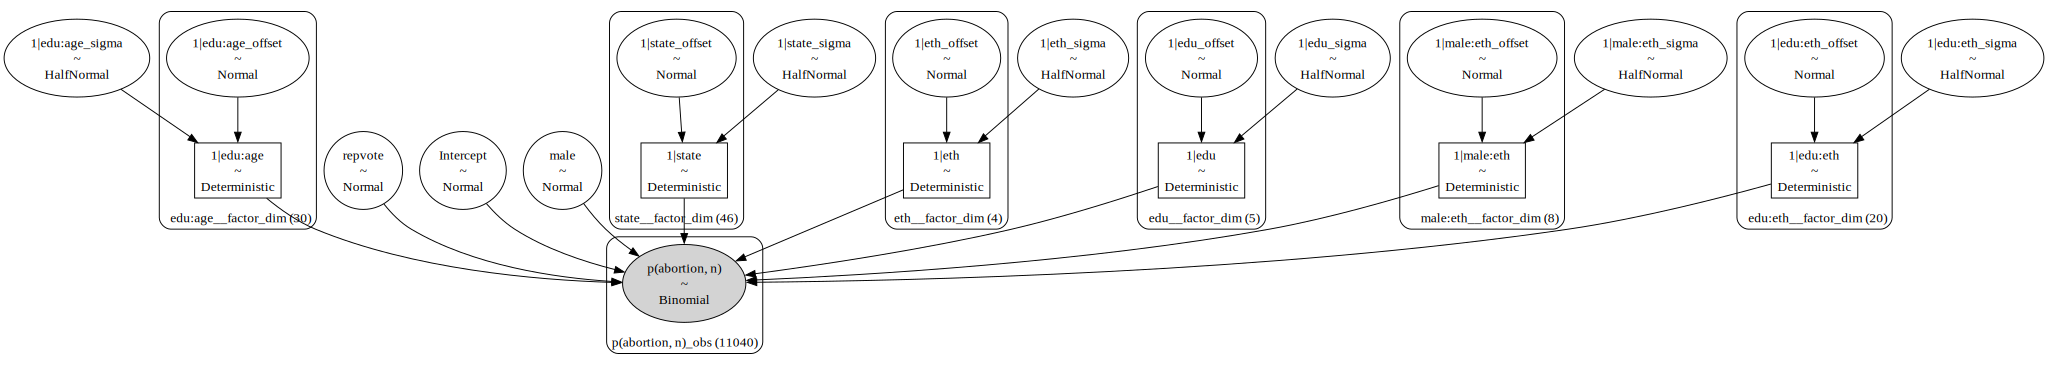

In [28]:
model_hierarchical.graph()

We then predict the outcomes implied by the biased sample. These predictions are to be adjusted by what we take to be the share of that demographic cohort in population. We can plot the posterior predictive distribution against the observed data from our biased sample to see that we have generally good fit to the distribution. 

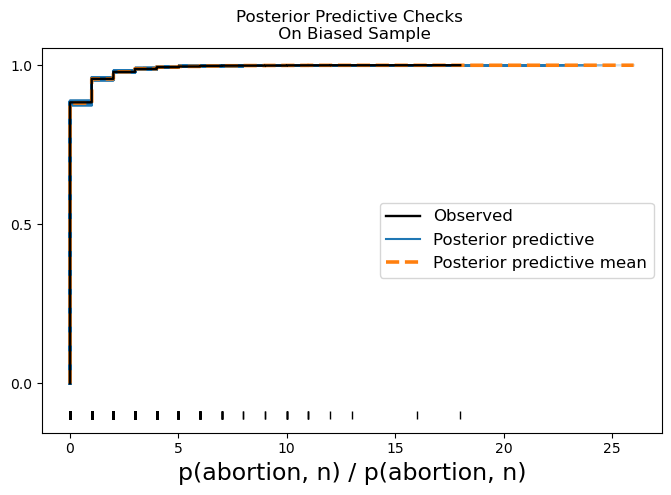

In [29]:
model_hierarchical.predict(result, kind="pps")
ax = az.plot_ppc(result, figsize=(8, 5), kind="cumulative", observed_rug=True)
ax.set_title("Posterior Predictive Checks \n On Biased Sample");

### Apply the Post-stratification Weighting

We now use the fitted model to predict the voting shares on the data where we use the genuine state numbers per strata. To do so we load data from the national census and augment our data set so as to be able to apply the appropriate weights.

In [30]:
poststrat_df = pd.read_csv("data/mr_p_poststrat_df.csv")

new_data = poststrat_df.merge(
    statelevel_predictors_df, left_on="state", right_on="state", how="left"
)
new_data.rename({"educ": "edu"}, axis=1, inplace=True)
new_data = model_df.merge(
    new_data,
    how="left",
    left_on=["state", "eth", "male", "age", "edu"],
    right_on=["state", "eth", "male", "age", "edu"],
).rename({"n_y": "n", "repvote_y": "repvote"}, axis=1)[
    ["state", "eth", "male", "age", "edu", "n", "repvote"]
]


new_data = new_data.merge(
    new_data.groupby("state").agg({"n": "sum"}).reset_index().rename({"n": "state_total"}, axis=1)
)
new_data["state_percent"] = new_data["n"] / new_data["state_total"]
new_data.head()

,state,eth,male,age,edu,n,repvote,state_total,state_percent
0,ID,White,-0.5,70+,HS,31503,0.683102,1193885,0.026387
1,ID,White,0.5,70+,4-Year College,11809,0.683102,1193885,0.009891
2,ID,White,0.5,70+,Post-grad,9873,0.683102,1193885,0.008270
3,ID,White,0.5,50-59,Some college,30456,0.683102,1193885,0.025510
4,ID,White,0.5,70+,HS,19898,0.683102,1193885,0.016667


In [31]:
result_adjust = model_hierarchical.predict(result, data=new_data, inplace=False, kind="pps")
result_adjust

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

### Make Adjustments by State

We need to adjust each state specific strata by the weight appropriate for each state to post-stratify the estimates. The formula here to adjust each state level prediction: 

$$
\theta_s^{MRP} = \frac{\sum_{j \in s} N_j \theta_j}{\sum_{j \in s} N_j}
$$

To do so we extract the indices for each strata in our data on a state by state basis. Then we weight the predicted estimate by the appropriate percentage on a state basis. 

In [32]:
estimates = []
abortion_posterior_base = az.extract(result, num_samples=2000)["p(abortion, n)_mean"]
abortion_posterior_mrp = az.extract(result_adjust, num_samples=2000)["p(abortion, n)_mean"]

for s in new_data["state"].unique():
    idx = new_data.index[new_data["state"] == s].tolist()
    predicted_mrp = (
        ((abortion_posterior_mrp[idx].mean(dim='sample') * new_data.iloc[idx]["state_percent"]))
        .sum()
        .item()
    )
    predicted_mrp_lb = (
        ((abortion_posterior_mrp[idx].quantile(0.025, dim='sample') * new_data.iloc[idx]["state_percent"]))
        .sum()
        .item()
    )
    predicted_mrp_ub = (
        ((abortion_posterior_mrp[idx].quantile(0.975, dim='sample') * new_data.iloc[idx]["state_percent"]))
        .sum()
        .item()
    )
    predicted = abortion_posterior_base[idx].mean().item()
    base_lb = abortion_posterior_base[idx].quantile(0.025).item()
    base_ub = abortion_posterior_base[idx].quantile(0.975).item()
    
    estimates.append([s, predicted, base_lb, base_ub, predicted_mrp, predicted_mrp_ub, predicted_mrp_lb])


state_predicted = pd.DataFrame(estimates, columns=["state", "base_expected", "base_lb", "base_ub", "adjusted", "ub", "lb"])

state_predicted = (
    state_predicted.merge(cces_all_df.groupby("state")[["abortion"]].mean().reset_index())
    .sort_values("adjusted")
    .rename({"abortion": "census_share"}, axis=1)
)
state_predicted.head()

,state,base_expected,base_lb,base_ub,adjusted,ub,lb,census_share
9,OK,0.422344,0.209548,0.658459,0.326496,0.412243,0.246757,0.321553
34,MS,0.437840,0.215256,0.682492,0.380658,0.492824,0.278824,0.374640
2,CO,0.475468,0.251428,0.697159,0.397698,0.483291,0.315567,0.354857
24,ME,0.437219,0.235827,0.665177,0.421139,0.539669,0.298316,0.403636
25,MO,0.510291,0.225359,0.744009,0.421991,0.527927,0.320247,0.302954


### Plot the Effect of Adjustment

These adjusted estimates can be plotted against the shares ascribed at the state level in the census. These adjustments provide a far better reflection of the national picture than the ones derived from the biased sample. 

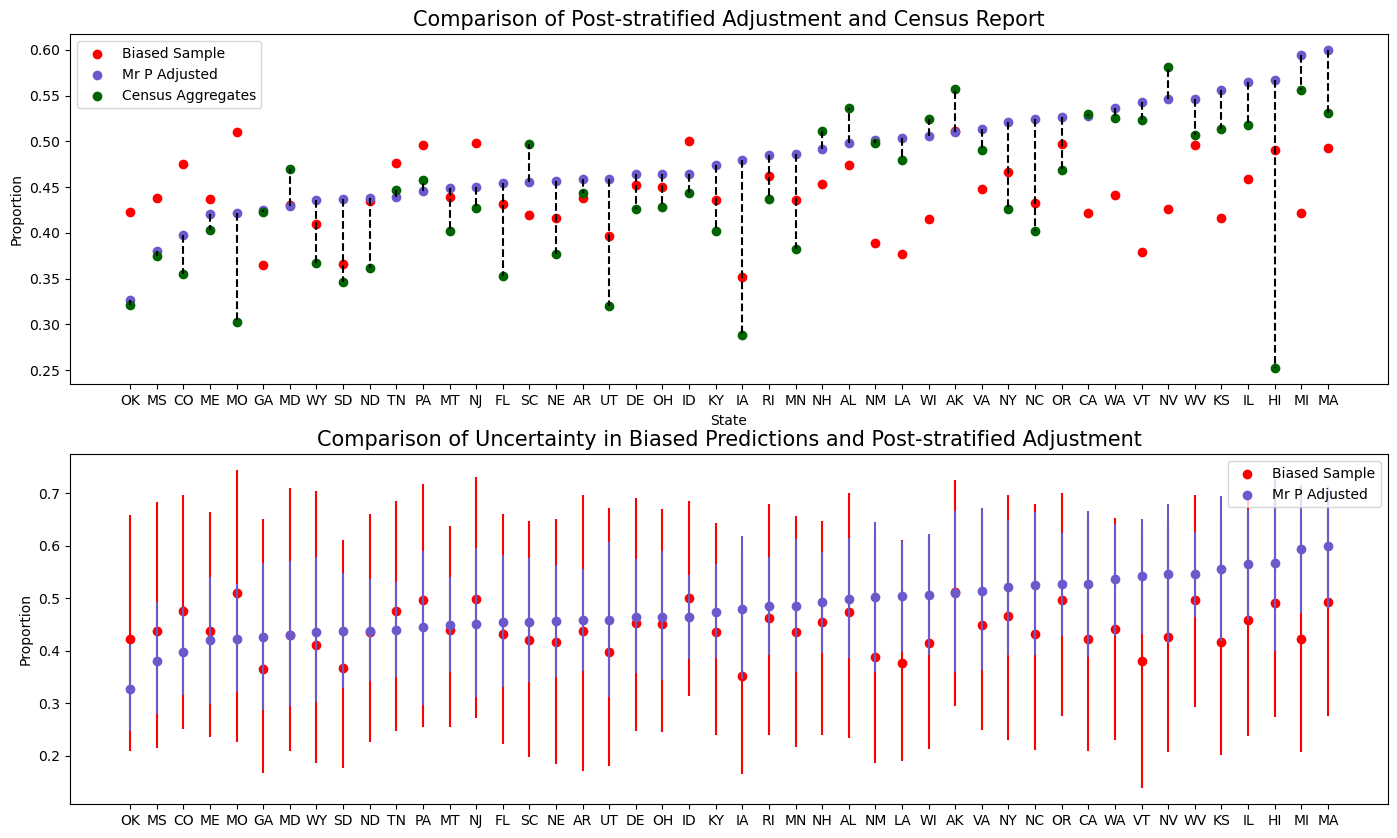

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(17, 10))
axs = axs.flatten()
ax = axs[0]
ax1 = axs[1]
ax.scatter(
    state_predicted["state"], state_predicted["base_expected"], color="red", label="Biased Sample"
)
ax.scatter(
    state_predicted["state"], state_predicted["adjusted"], color="slateblue", label="Mr P Adjusted"
)
ax.scatter(
    state_predicted["state"],
    state_predicted["census_share"],
    color="darkgreen",
    label="Census Aggregates",
)
ax.legend()
ax.vlines(
    state_predicted["state"],
    state_predicted["adjusted"],
    state_predicted["census_share"],
    color="black",
    linestyles="--",
)



ax1.scatter(
    state_predicted["state"], state_predicted["base_expected"], color="red", label="Biased Sample"
)
ax1.scatter(
    state_predicted["state"], state_predicted["adjusted"], color="slateblue", label="Mr P Adjusted"
)
ax1.legend()

ax1.vlines(
    state_predicted["state"],
    state_predicted["base_ub"],
    state_predicted["base_lb"],
    color='red'
)
ax1.vlines(
    state_predicted["state"],
    state_predicted["ub"],
    state_predicted["lb"],
    color="slateblue",
)
ax.set_xlabel("State")
ax.set_ylabel("Proportion")
ax1.set_title("Comparison of Uncertainty in Biased Predictions and Post-stratified Adjustment", fontsize=15);
ax.set_title("Comparison of Post-stratified Adjustment and Census Report", fontsize=15);
ax1.set_ylabel("Proportion");


## Conclusion

In this notebook we have seen how to use `bambi` to concisely and quickly apply the technique of multilevel regression and post-stratification. We've seen how this technique is a natural and compelling extension to regression modelling in general, that incorporates prior knowledge in an interesting and flexible manner. 

The problems of representation in data are serious. Policy gets made and changed on the basis of anticipated policy effects. Without the ability to control and adjust for non-representative samples, politicians and policy makers risk prioritising initiatives for a vocal majority among the represented in the sample.
The question of whether a given sample is "good" or "bad" cannot (at the time) ever be known, so some care needs to be taken when choosing to adjust your model of the data. Predictions made from sample data are powerful. It's not even an exaggeration to say that the fates of entire nations can hang on decisions made from poorly understood sampling procedures. 

Multilevel regression and post-stratification is an apt tool for making the adjustments required and guiding decisions makers in crucial policy choices, but it should be used carefully. 

